# Tutorial on using OpenPIV with PIV Uncertainty Quantification

Authors: @lento234, @alexlib


In [79]:
# If you have not installed pivuq yet:
# !conda activate openpiv 
# !pip install git+https://github.com/lento234/pivuq

In [80]:
import pivuq

In [81]:
from openpiv import tools, pyprocess, scaling, validation, filters
import numpy as np

import os



In [82]:
## Obtain images and ground truth data from pivuq 

In [83]:
# we can run it from any folder
# path = os.path.dirname(os.path.abspath(__file__))


frame_a  = tools.imread( 'https://github.com/lento234/pivuq/raw/main/examples/data/particledisparity_code_testdata/B00010.tif')
frame_b  = tools.imread( 'https://github.com/lento234/pivuq/raw/main/examples/data/particledisparity_code_testdata/B00011.tif')

image_pair = [frame_a, frame_b]

# frame_a = (frame_a*1024).astype(np.int32)
# frame_b = (frame_b*1024).astype(np.int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


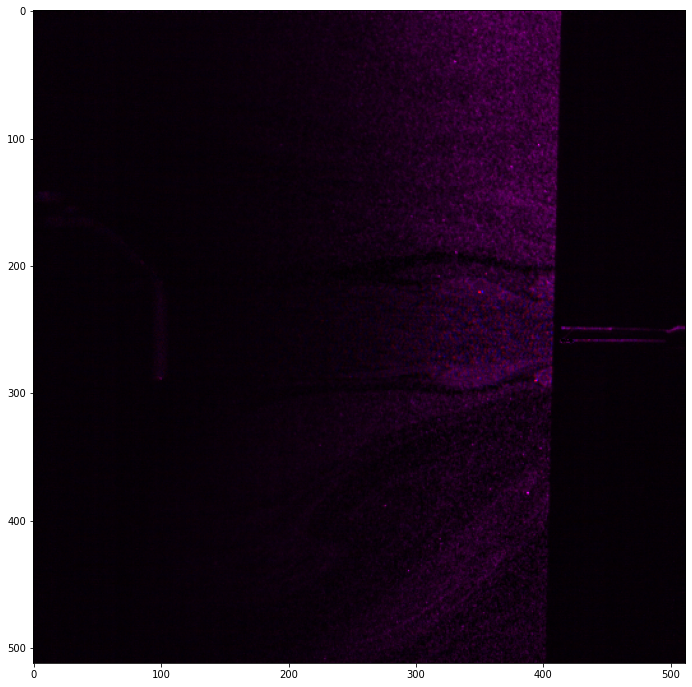

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.imshow(np.stack([frame_a,0*frame_b,frame_b],axis=2))

In [85]:
u, v, sig2noise = pyprocess.extended_search_area_piv( frame_a, frame_b, \
    window_size=16, overlap=8, dt=1, search_area_size=32, sig2noise_method='peak2peak' )

# print(u,v,sig2noise)

x, y = pyprocess.get_coordinates( image_size=frame_a.shape, search_area_size=32, overlap=8 )
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.3 )
u, v, mask = validation.global_val( u, v, (-1000, 2000), (-1000, 1000) )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )


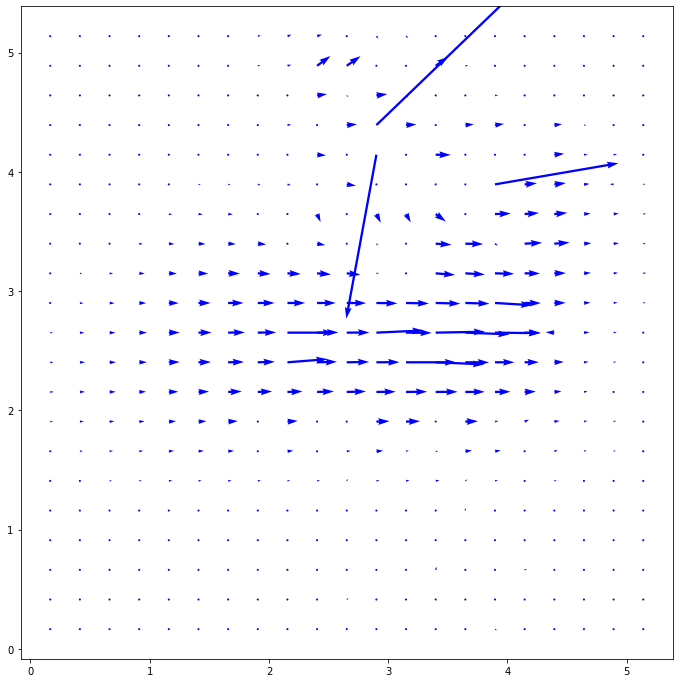

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

In [86]:
tools.save(x, y, u, v, mask, 'test_uq.vec' )

fig, ax = plt.subplots(figsize=(12,12))

tools.display_vector_field('test_uq.vec', scale=0.5, width=0.0035, ax = ax)

In [87]:
data = np.loadtxt('test_uq.vec', skiprows=1).T

I, J = np.unique(data[0]).shape[0], np.unique(data[1]).shape[0]
X = np.reshape(data[0], (I, J))   # zero-index
Y = np.reshape(data[1], (I, J)) 
U = np.stack((np.reshape(data[2], (I, J)), np.reshape(data[3], (I, J))))

[Text(0.5, 1.0, 'Magnitude')]

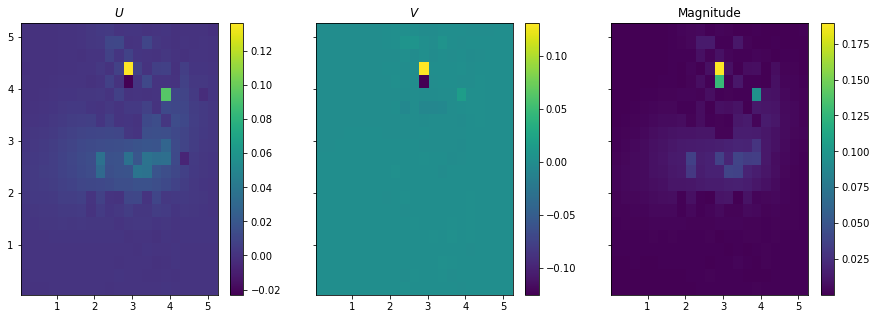

In [88]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 5))

for i, (ax, var) in enumerate(zip(axes[:2], ["U", "V"])):
    im = ax.pcolormesh(X, Y, U[i])
    fig.colorbar(im, ax=ax)
    ax.set(title=f"${var}$")

ax = axes[-1]
im = ax.pcolormesh(X, Y, np.linalg.norm(U, axis=0))
fig.colorbar(im, ax=ax)
ax.set(title="Magnitude")

# for ax in axes:
#     ax.set(xlim=(200, 400), ylim=(100, 400), xlabel="$j$", ylabel="$i$")

In [89]:

%%time
warped_image_pair = pivuq.warp(
    image_pair,
    U,
    velocity_upsample_kind="linear",
    direction="center",
    nsteps=5,
    order=1,
)

Wall time: 293 ms


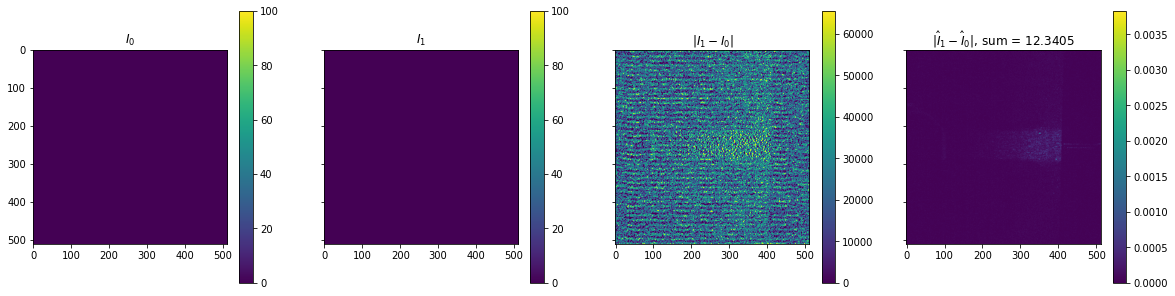

In [91]:
fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20, 5))

for i, ax in enumerate(axes[:2]):
    im = ax.imshow(warped_image_pair[0], vmax=100)
    fig.colorbar(im, ax=ax)
    ax.set(title=f"$I_{i}$")

ax = axes[-2]
im = ax.imshow(np.abs(image_pair[1] - image_pair[0]))
fig.colorbar(im, ax=ax)
ax.set(title="$|I_1 - I_0|$")


ax = axes[-1]
im = ax.imshow(np.abs(warped_image_pair[1] - warped_image_pair[0]))
fig.colorbar(im, ax=ax)
ax.set(title=f"$|\hat{{I}}_1 - \hat{{I}}_0|$, sum = {np.abs(warped_image_pair[1] - warped_image_pair[0]).sum():g}");

# for ax in axes:
#     ax.set(xlim=(200, 400), ylim=(100, 400), xlabel="$j$", ylabel="$i$")